In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn import linear_model
import csv
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix

def getData(filename):
    # images are 48x48
    Y = []
    X = []
    first = True
    
    for line in open(filename):

        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])
    X,Y = np.array(X).reshape(-1,48,48), np.array(Y)
    return X, Y

X, Y = getData('fer2013.csv')


X_Train, X_Test, Y_Train, Y_Test=train_test_split(X, Y, test_size=0.1, random_state=0)
X_Train=X_Train.astype(np.uint8)
X_Test=X_Test.astype(np.uint8)
sift = cv2.xfeatures2d.SIFT_create()



In [2]:
def Key_Features(X):
    descriptor=np.array([])
    for i in range(len(X)):
        kp, des = sift.detectAndCompute(X[i],None)
        if i==0:
            descriptor=des
            continue
        if np.shape(des) == ():
            continue
        descriptor=np.vstack((descriptor,des))
    return descriptor
    
def descriptor(X,Y):
    Img_desc=[]
    for i in range(len(X)):
        kp, des = sift.detectAndCompute(X[i],None)
        if np.shape(des) == ():
            Y=np.delete(Y,Y[i])
            continue
        Img_desc.append(des)
    return Img_desc, Y



In [3]:
# if you use a save model then turn it True ,otherwise if you run the whole code turn it False
is_model_saved = True
if(is_model_saved==False ): 
    Key_Features= Key_Features(X_Train)
    kmeans = KMeans(n_clusters=2000, random_state=0).fit(Key_Features)
    joblib.dump(kmeans, 'sift_model.pkl')
else:
    print('load model')
    kmeans = joblib.load('sift_model.pkl')

load model


In [4]:

def Features_SVM(data):
    X=[]
    for i in data:
        x=kmeans.predict(i)
        a,b=np.histogram(x,bins=2000,range=(-0.5,1999.5))
        X.append(a)
    return X


    

In [5]:
x_train, y_train_svm = descriptor(X_Train,Y_Train)
x_test, y_test_svm = descriptor(X_Test,Y_Test)
x_train_svm = Features_SVM(x_train)
x_test_svm = Features_SVM(x_test)
lin_clf = linear_model.SGDClassifier()
lin_clf.fit(x_train_svm,y_train_svm)

/home/hfahad/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [6]:
def accuracy(Y_actual,Y_predicted):
    j=0
    for i in range(len(Y_predicted)):
        if Y_actual[i]==Y_predicted[i]:
            j=j+1
    return (j/len(Y_predicted))
    
Y_predict=lin_clf.predict(x_test_svm)
print(accuracy(Y_predict,y_test_svm))


0.15858416945373466


Normalized confusion matrix
[[0.15 0.02 0.18 0.15 0.23 0.05 0.21]
 [0.12 0.02 0.2  0.09 0.32 0.09 0.16]
 [0.15 0.01 0.18 0.18 0.23 0.08 0.17]
 [0.18 0.02 0.17 0.16 0.24 0.05 0.19]
 [0.18 0.01 0.17 0.17 0.21 0.06 0.19]
 [0.17 0.02 0.19 0.17 0.19 0.07 0.19]
 [0.18 0.02 0.17 0.14 0.25 0.06 0.18]]


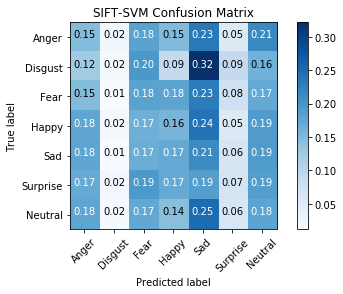

In [7]:
import itertools
import numpy as np
import matplotlib.pyplot as plt



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix =confusion_matrix(y_test_svm,Y_predict, labels=None, sample_weight=None)
np.set_printoptions(precision=2)
class_names = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']


plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='SIFT-SVM Confusion Matrix')

plt.show()


In [8]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test_svm,Y_predict)

(array([0.12, 0.02, 0.14, 0.25, 0.16, 0.13, 0.15]),
 array([0.15, 0.02, 0.18, 0.16, 0.21, 0.07, 0.18]),
 array([0.13, 0.02, 0.16, 0.19, 0.18, 0.09, 0.17]),
 array([484,  56, 501, 920, 599, 442, 586]))